#DiaSources Analysis

In [314]:
import lsst.meas.astrom as measAstrom
import lsst.daf.base as dafBase
import lsst.pipe.base as pipeBase
import lsst.daf.persistence as dafPersist

import random
import matplotlib.pyplot as plt
import numpy as np

import lsst.afw.display.ds9 as ds9
import lsst.afw.table as afwTable

import lsst.afw.geom as afwGeom
import lsst.afw.display.utils as displayUtils

This is the butler reference that we use on our working dataset. DATADIR is where our data is, obviously

In [315]:
#DATADIR="/renoir_data_02/jpreyes/lsst_data/CFHTLS_v11/"
DATADIR="/renoir_data_02/jpreyes/lsst_data/CFHTLS_master/"
butler = dafPersist.Butler(DATADIR+"/output")


We create a list with all our diaSources Catalog (one for each visit)

In [316]:
subset = butler.subset("deepDiff_diaSrc")
#file = open("diaSources.txt", "w")
diaSourcesList = []
for dr_subSet in subset:
    if dr_subSet.dataId["ccd"]==14:
        #file.write("visit="+str(dr_subSet.dataId["visit"])+"\n")
        try:
            diaSourcesList.append(dr_subSet)
           
        except:
            pass
            

#file.close()

In [317]:
dataId = {'visit': 800719, 'filter':'r' , 'ccd':14}
diaSrcs = butler.get("deepDiff_diaSrc", dataId)
diffExp = butler.get("deepDiff_differenceExp", dataId)

In [318]:
ds9.mtv(diffExp, frame=1)

In [319]:
ds = random.choice(diaSrcs)
ds.get("base_CircularApertureFlux_6_0_fluxSigma")

1056.855224609375

In [378]:
def plot_fluxes_from_diasources_list(diaSources, flux_variable, class_flux=10000, limit_flux=50000, bins=100):
   
    fluxes =[]
    sigmaPos = []
    sigmaNeg = []
    sigmas = []

    for diaSrc in diaSrcs:
    
        flux = diaSrc.get(flux_variable)
        #ds9.dot("o", x, y, size = 25, frame=3)
        x = diaSrc.get("ip_diffim_NaiveDipoleCentroid_x")
        y = diaSrc.get("ip_diffim_NaiveDipoleCentroid_y")
        if np.abs(flux) < limit_flux:
            fluxes.append(flux)
            
          
        if np.isnan(flux) == False:
            if flux > 0:
                sigmaPos.append(diaSrc.get(flux_variable+"Sigma"))
                sigmas.append(diaSrc.get(flux_variable+"Sigma"))
            else:
                sigmaNeg.append(diaSrc.get(flux_variable+"Sigma")) 
                sigmas.append(diaSrc.get(flux_variable+"Sigma"))
                
    meanSigmaPos = np.mean(sigmas)
    meanSigmaNeg = np.mean(sigmas)
    

    
    plot_fluxes(fluxes, meanSigmaPos, meanSigmaNeg, title=flux_variable, class_flux=class_flux, limit_flux=limit_flux, bins=bins)
    

def plot_fluxes(fluxes, positive_sigma, negative_sigma, title="", class_flux=10000, limit_flux=50000, bins=100):

  
    
    N, bins, patches = plt.hist(fluxes, bins=bins)

    for bin_size, bin, patch in zip(N, bins, patches):
        if bin > class_flux:
            patch.set_facecolor('g')
        elif bin < -class_flux:
            patch.set_facecolor('r')
 


    plt.axvline(positive_sigma*5, color='y', linestyle='dashed', linewidth=2)
    plt.axvline(-(negative_sigma*5), color='y', linestyle='dashed', linewidth=2)
    plt.title(title)
    plt.xlabel("Flux value")
    plt.ylabel("Sources")
    ax=plt.axes()
    ax.set_xlim(xmin=-limit_flux, xmax=limit_flux)
                
                
                
    plt.show()

In [321]:

def get_stamps_for_diaSource(diaSource, scienceExposure, templateExposure, subtractedExposure, show_stamps=False, frame=1):
    try:
    
        bbox = diaSource.getFootprint().getBBox()

        mos = displayUtils.Mosaic()
        Begin = afwGeom.Point2I(bbox.getBeginX(), bbox.getBeginY())
        End = afwGeom.Point2I(bbox.getEndX(), bbox.getEndY())

        ExpOrig = afwGeom.Point2I(scienceExposure.getX0()-1, scienceExposure.getY0()-1)



        correctedBegin = bbox.getBegin()- ExpOrig
        correctedEnd = bbox.getEnd() - ExpOrig

        correctedBegin= afwGeom.Point2I(correctedBegin.getX()-10,correctedBegin.getY()-10 )
        correctedEnd = afwGeom.Point2I(correctedEnd.getX()+10,correctedEnd.getY()+10 )



        bboxT = afwGeom.Box2I(correctedBegin,correctedEnd)

        #print bboxT.toString
        stamp_science = scienceExposure.Factory(scienceExposure,bboxT, True)
        im = displayUtils.Mosaic(gutter=5, background=5, mode="x")
        im.append(stamp_science.getMaskedImage())


        stamp_template = templateExposure.Factory(templateExposure,bboxT, True)
        #im = displayUtils.Mosaic(gutter=0, background=0, mode="x")
        im.append(stamp_template.getMaskedImage())



        stamp_subtracted = subtractedExposure.Factory(subtractedExposure,bboxT, True)
        #im = displayUtils.Mosaic(gutter=0, background=0, mode="x")
        im.append(stamp_subtracted.getMaskedImage())


        if show_stamps == True:
            ds9.mtv(stamp_science, frame=frame)
            frame+=1
            ds9.mtv(stamp_template, frame=2)
            frame+=1
            ds9.mtv(stamp_subtracted, frame=3)
    except:
        return False, False, False
        
    return stamp_science, stamp_template, stamp_subtracted

In [322]:
def get_array_from_stamp(stamp):
    mi = stamp.getMaskedImage()
    mask = mi.getMask()
    pixels_in_mask =0


    values_out = []
    values_in = []

    bitmask_detected = mask.getPlaneBitMask("DETECTED")
    bitmask_detected_neg = mask.getPlaneBitMask("DETECTED_NEGATIVE")
    #bitmask_detected_test = mask.getPlaneBitMask("DETECTED_TEST")
    #print "///"
    #print bitmask
    #print "///"

    for x in range(0, mi.getWidth()):
        
        for y in range (0, mi.getHeight()):
            if np.isnan(mi.getImage().get(x,y))==False:
                u =  mi.getMask()[x,y]

                if u.get(0,0) & bitmask_detected == 0 and u.get(0,0) & bitmask_detected_neg == 0:
                #if u.get(0,0) & bitmask_detected_test == 0:
                    values_out.append(mi.getImage().get(x,y))
                else:
                    values_in.append(mi.getImage().get(x,y))
                    pixels_in_mask += 1

    return values_out, values_in, pixels_in_mask

In [323]:
def add_circular_ap_mask(stamp, radius=6):
    
    
    mi = stamp.getMaskedImage()
    mask = mi.getMask()
    mask.addMaskPlane('DETECTED_TEST')
    m_bit_test = mask.getPlaneBitMask('DETECTED_TEST')
    cx = mi.getWidth()/2
    cy = mi.getHeight()/2
    
    
    for x in range(0, mi.getWidth()):        
        for y in range (0, mi.getHeight()):
            u =  mi.getMask()[x,y]  

            if np.isnan(mi.getImage().get(x,y))==False and (x-cx)*(x-cx)+(y-cy)*(y-cy) < radius*radius:
                u =  mi.getMask()[x,y]            
                u.set(0,0,m_or | m_bit_test)
                
    
    
    return stamp

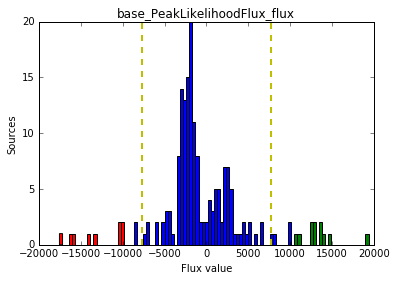

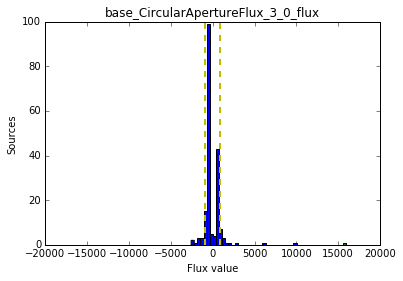

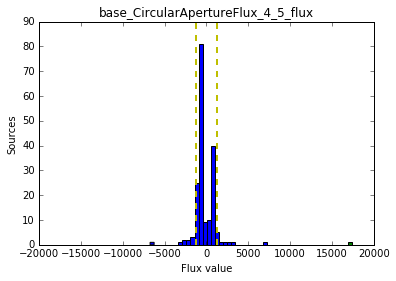

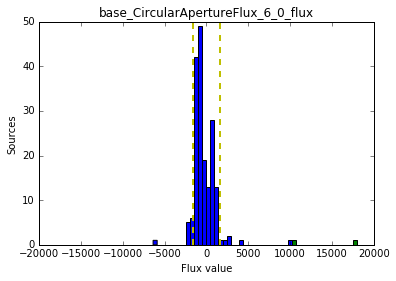

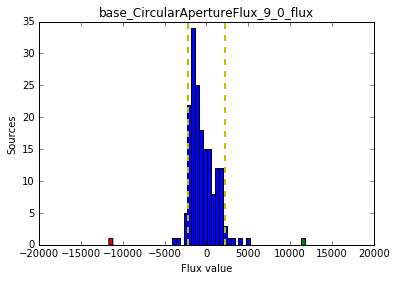

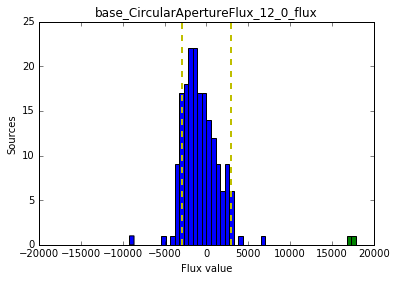

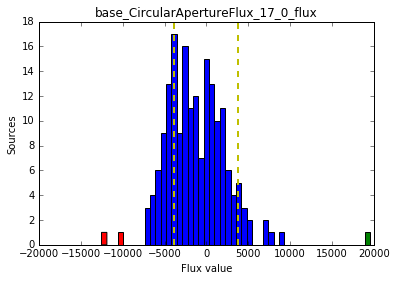

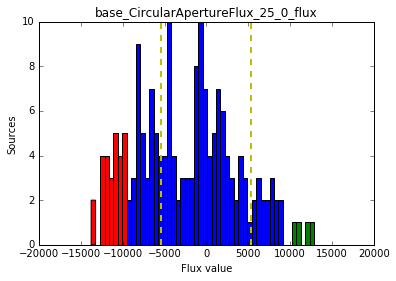

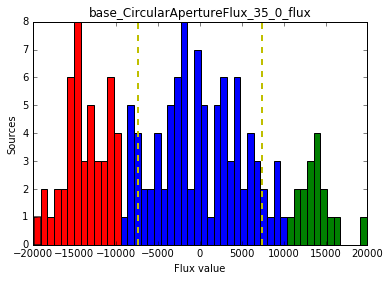

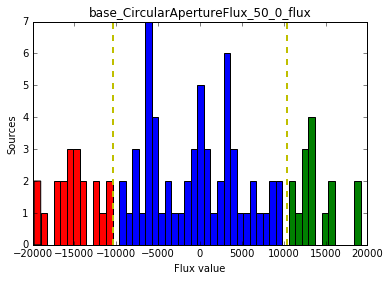

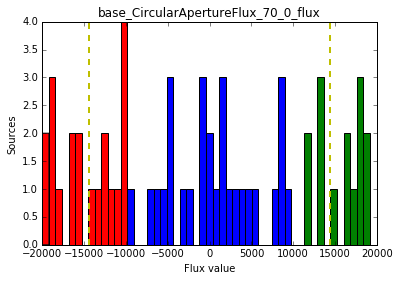

In [379]:
%matplotlib inline


plot_fluxes_from_diasources_list(diaSrcs,"base_PeakLikelihoodFlux_flux", limit_flux=20000, bins = 100)
plot_fluxes_from_diasources_list(diaSrcs,"base_CircularApertureFlux_3_0_flux", limit_flux=20000, bins = 50)
plot_fluxes_from_diasources_list(diaSrcs,"base_CircularApertureFlux_4_5_flux", limit_flux=20000, bins = 50)
plot_fluxes_from_diasources_list(diaSrcs,"base_CircularApertureFlux_6_0_flux", limit_flux=20000, bins = 50)
plot_fluxes_from_diasources_list(diaSrcs,"base_CircularApertureFlux_9_0_flux", limit_flux=20000, bins = 50)
plot_fluxes_from_diasources_list(diaSrcs,"base_CircularApertureFlux_12_0_flux", limit_flux=20000, bins = 50)
plot_fluxes_from_diasources_list(diaSrcs,"base_CircularApertureFlux_17_0_flux", limit_flux=20000, bins = 50)
plot_fluxes_from_diasources_list(diaSrcs,"base_CircularApertureFlux_25_0_flux", limit_flux=20000, bins = 50)
plot_fluxes_from_diasources_list(diaSrcs,"base_CircularApertureFlux_35_0_flux", limit_flux=20000, bins = 50)
plot_fluxes_from_diasources_list(diaSrcs,"base_CircularApertureFlux_50_0_flux", limit_flux=20000, bins = 50)
plot_fluxes_from_diasources_list(diaSrcs,"base_CircularApertureFlux_70_0_flux", limit_flux=20000, bins = 50)

In [325]:
ds = random.choice(diaSrcs)


In [326]:

scienceExposure =  butler.get("calexp", {"visit":800719, "ccd":14, "filter":"r"})
templateExposure = butler.get("deepDiff_warpedExp", {"visit":800719, "ccd":14, "filter":"r"})
subtractedExposure = diffExp

ds9.mtv(scienceExposure, frame=1)
ds9.mtv(templateExposure, frame=2)
ds9.mtv(subtractedExposure, frame=3)

In [327]:
#

fluxes = []
fluxes_s = []
fluxes_t = []
fluxes_d = []

sigmas = []
sigmas_s =[]
sigmas_t =[]
sigmas_d = []

for ds in diaSrcs:

    flux = ds.get("base_CircularApertureFlux_6_0_flux")
    sigma = ds.get("base_CircularApertureFlux_6_0_fluxSigma")
    

    
    stamp_s, stamp_t, stamp_d = get_stamps_for_diaSource(ds, scienceExposure, templateExposure, subtractedExposure)
    if stamp_s != False:
        #THIS PART HAS TO BE MODIFIED IF WE WANT TO USE THE PRE-EXISTING MASK. COMMENT IF NOT INTERESTED!
        #stamp_d == add_circular_ap_mask(stamp_d)
        #stamp_s == add_circular_ap_mask(stamp_s)
        #stamp_t == add_circular_ap_mask(stamp_t)

        values_out_s, values_in_s, m_pixels_s = get_array_from_stamp(stamp_s)
        values_out_t, values_in_t, m_pixels_t = get_array_from_stamp(stamp_t)
        values_out_d, values_in_d, m_pixels_d = get_array_from_stamp(stamp_d)

        fluxes.append(flux)
        fluxes_s.append(np.sum(values_in_s))
        fluxes_t.append(np.sum(values_in_t))
        fluxes_d.append(np.sum(values_in_d))

        sigmas.append(sigma)

        sigmas_s.append(np.sqrt(m_pixels_s)*np.std(values_out_s))
        sigmas_t.append(np.sqrt(m_pixels_t)*np.std(values_out_t))
        sigmas_d.append(np.sqrt(m_pixels_d)*np.std(values_out_d))


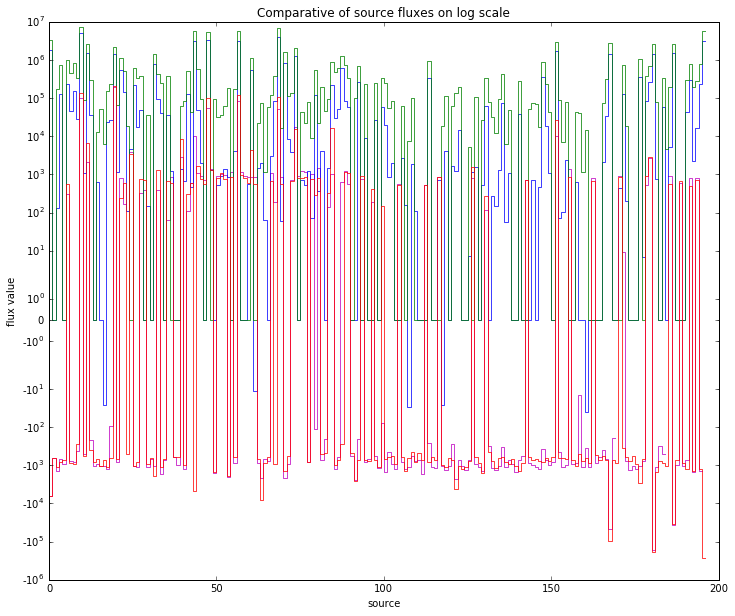

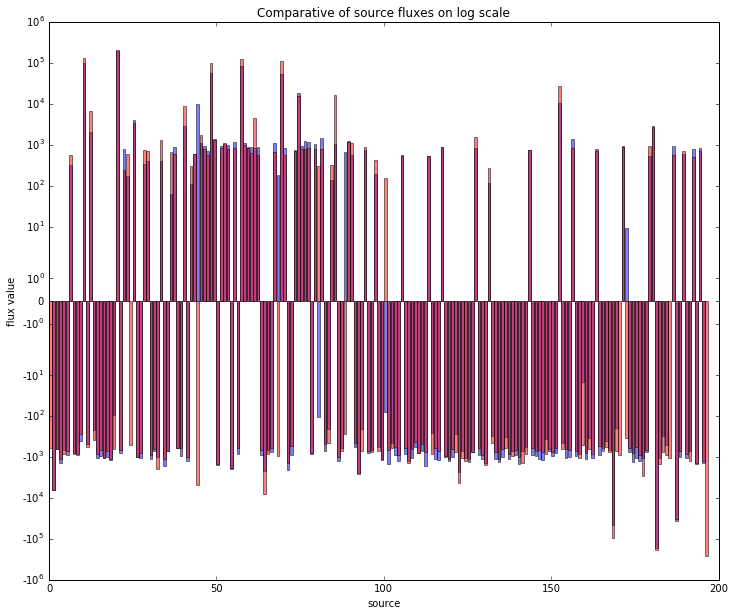

In [328]:
sources = list(range(len(fluxes)))

plt.figure(figsize=(12,10))
plt.plot(sources,fluxes, color='m', ls='steps', alpha=0.75, label='flux on diaSource with ap 6.0')
plt.plot(sources, fluxes_s, color='b', ls='steps', alpha=0.75,label='flux on science image')
plt.plot(sources, fluxes_t, color='g', ls='steps',alpha=0.75,label='flux on template image')
plt.plot(sources, fluxes_d, color='r', ls='steps',alpha=0.75,label='flux on difference image')
plt.title('Comparative of source fluxes on log scale')
plt.xlabel("source")
plt.ylabel("flux value")
#plt.legend()
ax=plt.axes()
ax.set_yscale('symlog')
plt.show()

plt.figure(figsize=(12,10))
plt.bar(sources,fluxes, color='b', alpha=0.5, label='flux on diaSource with ap 6.0')
plt.bar(sources, fluxes_d, color='r', alpha=0.5,label='flux on difference image')
plt.title('Comparative of source fluxes on log scale')
plt.xlabel("source")
plt.ylabel("flux value")
#plt.legend()
ax=plt.axes()
ax.set_yscale('symlog')
plt.show()

fluxes = np.nan_to_num(fluxes)



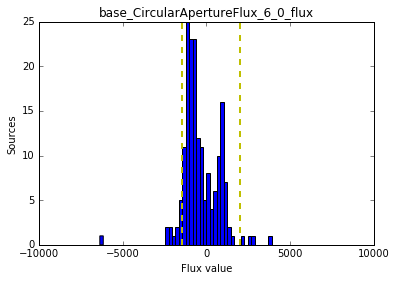

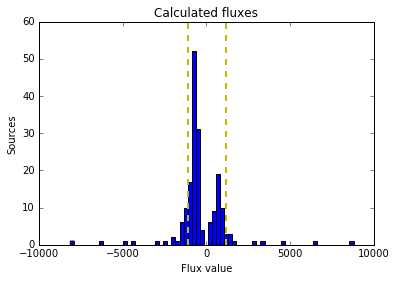

In [329]:
plot_fluxes_from_diasources_list(diaSrcs,"base_CircularApertureFlux_6_0_flux", limit_flux=10000, bins = 50)

sigmas_d_pos=[]
sigmas_d_neg=[]

fixed_fluxes =[]
for flux, sigma in zip(fluxes_d, sigmas_d):
    
    if np.abs(flux) < 20000:
        fixed_fluxes.append(flux)
        if np.isnan(sigma)==False:
            if flux < 0:
                sigmas_d_neg.append(sigma)
            elif flux > 0:
                sigmas_d_pos.append(sigma)
    



plot_fluxes(fixed_fluxes, np.mean(sigmas_d_pos), np.mean(sigmas_d_neg), title="Calculated fluxes", limit_flux=10000, bins = 100)

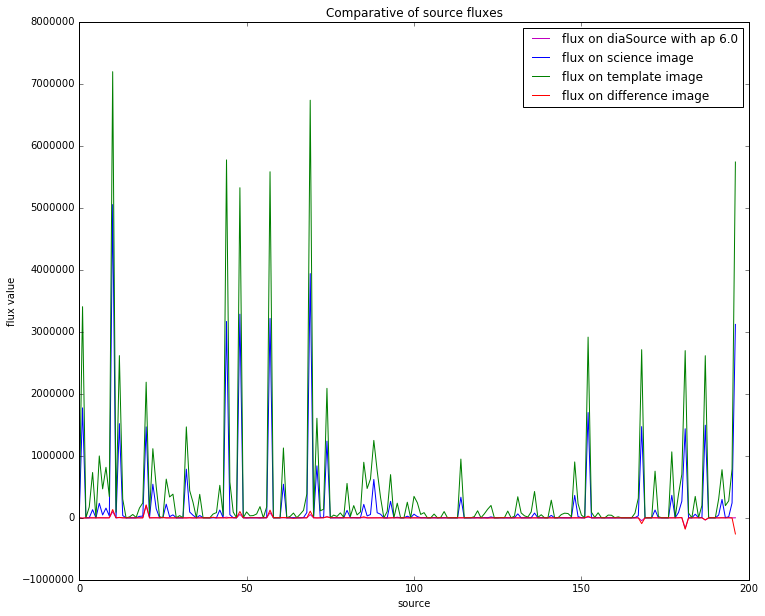

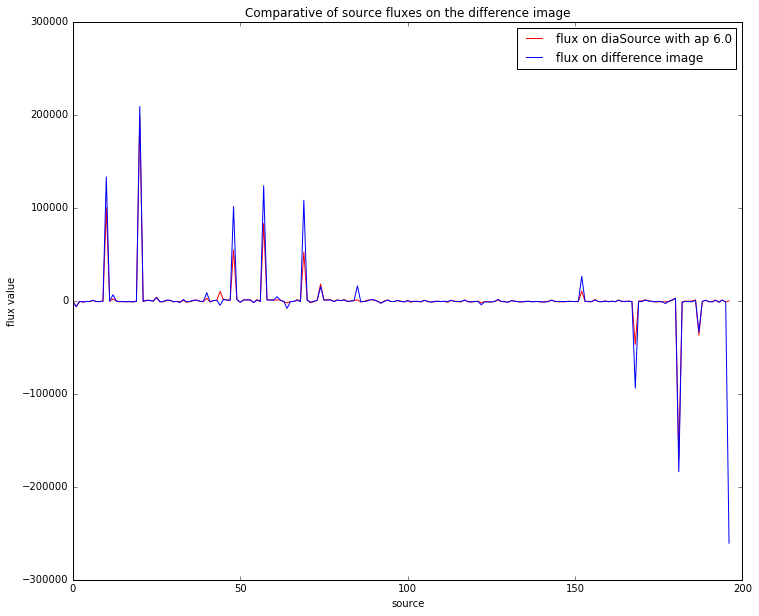

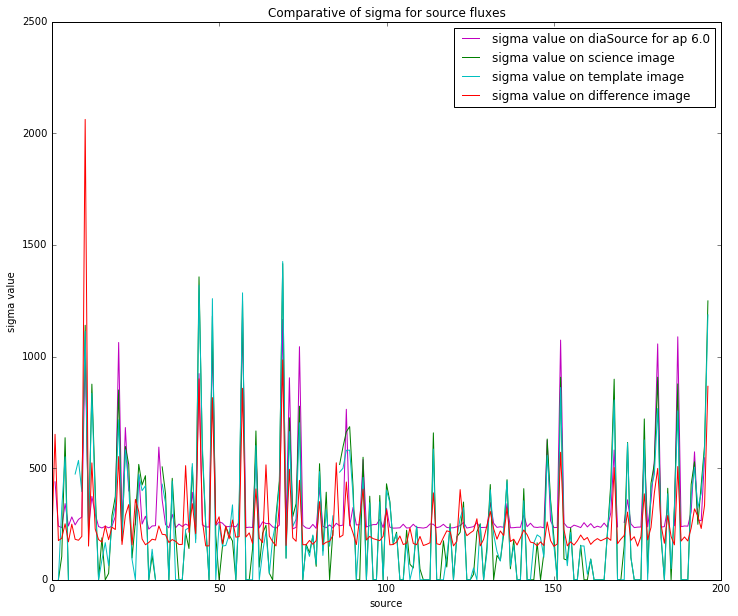

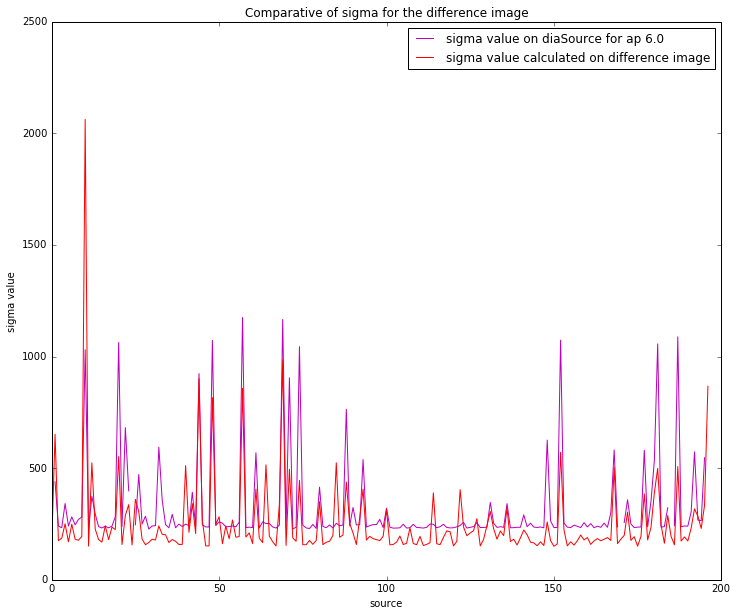

In [330]:
sources = list(range(len(fluxes)))


plt.figure(figsize=(12,10))
#plt.plot(sources, fluxes_d, 'b')
plt.plot(sources,fluxes, color='m', label='flux on diaSource with ap 6.0')
plt.plot(sources, fluxes_s, color='b', label='flux on science image')
plt.plot(sources, fluxes_t, color='g', label='flux on template image')
plt.plot(sources, fluxes_d, color='r', label='flux on difference image')
plt.title('Comparative of source fluxes')
plt.xlabel("source")
plt.ylabel("flux value")
plt.legend()
plt.show()

plt.figure(figsize=(12,10))
#plt.plot(sources, fluxes_d, 'b')
plt.plot(sources,fluxes, color='r', label='flux on diaSource with ap 6.0')
plt.plot(sources, fluxes_d, color='b', label='flux on difference image')
plt.title('Comparative of source fluxes on the difference image')
plt.xlabel("source")
plt.ylabel("flux value")
plt.legend()
plt.show()

plt.figure(figsize=(12,10))
plt.plot(sources,sigmas, 'm', label='sigma value on diaSource for ap 6.0')
plt.plot(sources, sigmas_s, 'g', label='sigma value on science image')
plt.plot(sources, sigmas_t, 'c', label='sigma value on template image')
plt.plot(sources, sigmas_d, 'r', label='sigma value on difference image')
plt.title('Comparative of sigma for source fluxes')
plt.xlabel("source")
plt.ylabel("sigma value")
plt.legend()
plt.show()


plt.figure(figsize=(12,10))
plt.plot(sources,sigmas, 'm', label='sigma value on diaSource for ap 6.0')
plt.plot(sources, sigmas_d, 'r', label='sigma value calculated on difference image')
plt.title('Comparative of sigma for the difference image')
plt.xlabel("source")
plt.ylabel("sigma value")
plt.legend()
ax=plt.axes()
ax.set_ylim(ymin=0)
plt.show()

In [331]:
for i,f in enumerate(fluxes):
    if np.isnan(f) == True:
      fluxes[i] = 0  

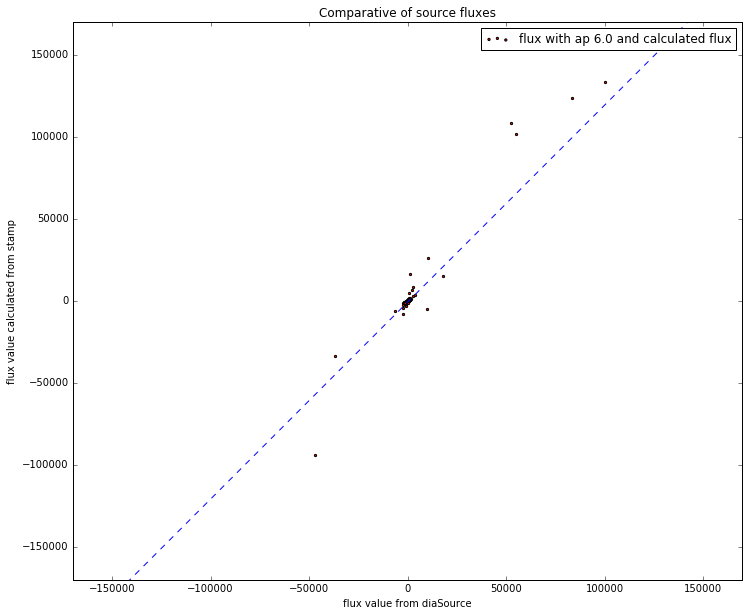

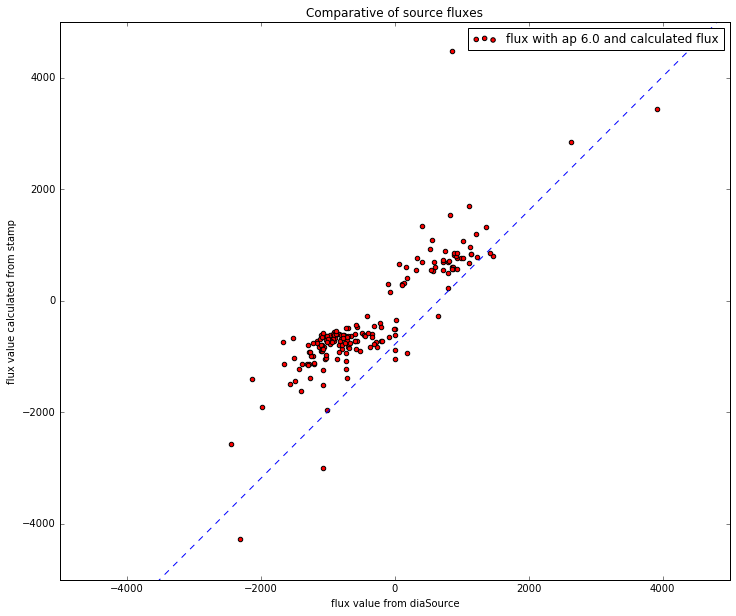

In [332]:
sources = list(range(len(fluxes)))

z = np.polyfit(fluxes,fluxes_d,1)
p = np.poly1d(z)

fmax = np.max(fluxes)
fmin = np.min(fluxes)
plt.figure(figsize=(12,10))
#plt.plot(sources, fluxes_d, 'b')
plt.scatter(fluxes,fluxes_d, c='r', s=5, label='flux with ap 6.0 and calculated flux')
#plt.plot(sources, fluxes_s, color='b', label='flux on science image')
#plt.plot(sources, fluxes_t, color='g', label='flux on template image')
#plt.plot(sources, fluxes_d, color='r', label='flux on difference image')
plt.title('Comparative of source fluxes')
plt.xlabel("flux value from diaSource")
plt.ylabel("flux value calculated from stamp")
plt.plot([fmin, fmax],[p(fmin), p(fmax)], 'b--')
ax = plt.axes()
ax.set_xlim(xmin=-170000, xmax=170000)
ax.set_ylim(ymin=-170000, ymax=170000)
plt.legend()
plt.show()

plt.figure(figsize=(12,10))
#plt.plot(sources, fluxes_d, 'b')
plt.scatter(fluxes,fluxes_d, c='r', s=20, label='flux with ap 6.0 and calculated flux')
#plt.plot(sources, fluxes_s, color='b', label='flux on science image')
#plt.plot(sources, fluxes_t, color='g', label='flux on template image')
#plt.plot(sources, fluxes_d, color='r', label='flux on difference image')
plt.title('Comparative of source fluxes')
plt.xlabel("flux value from diaSource")
plt.ylabel("flux value calculated from stamp")
plt.plot([fmin, fmax],[p(fmin), p(fmax)], 'b--')
ax = plt.axes()
ax.set_xlim(xmin=-5000, xmax=5000)
ax.set_ylim(ymin=-5000, ymax=5000)
plt.legend()
plt.show()


In [333]:
ss = list(sigmas)
ss_d = list(sigmas_d)

for i,s in enumerate(ss):
    if s == np.inf:
        ss.remove(s)
        ss_d.pop(i)

In [334]:
z = np.polyfit(ss,ss_d,1)
p = np.poly1d(z)

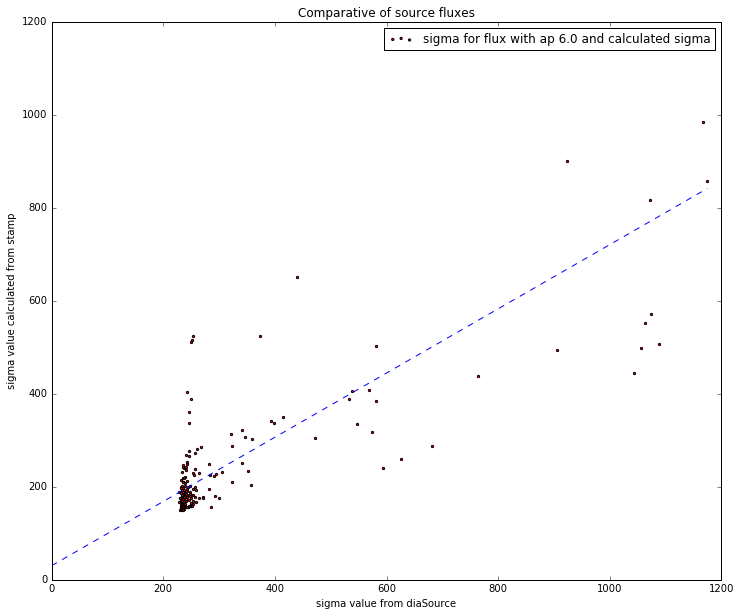

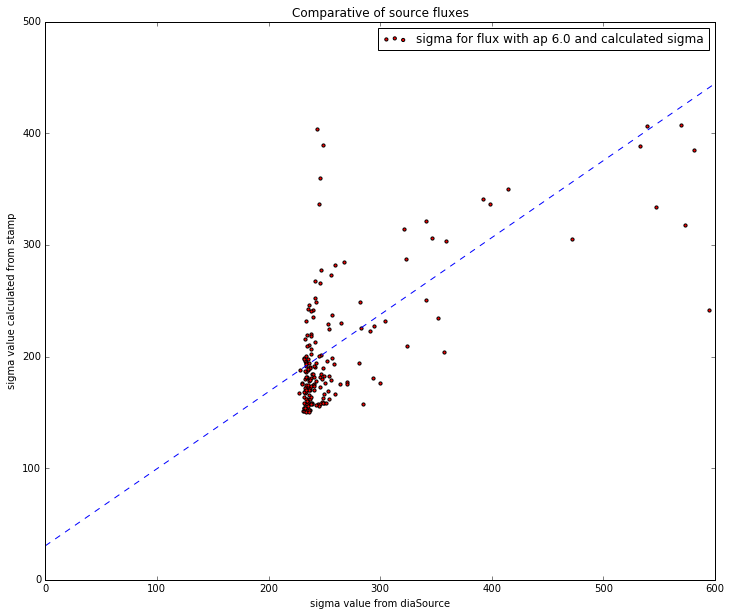

In [335]:
sources = list(range(len(ss)))



fmax = np.max(ss)
fmin = 0
plt.figure(figsize=(12,10))
#plt.plot(sources, fluxes_d, 'b')
plt.scatter(ss,ss_d, c='r', s=5, label='sigma for flux with ap 6.0 and calculated sigma')
#plt.plot(sources, fluxes_s, color='b', label='flux on science image')
#plt.plot(sources, fluxes_t, color='g', label='flux on template image')
#plt.plot(sources, fluxes_d, color='r', label='flux on difference image')
plt.title('Comparative of source fluxes')
plt.xlabel("sigma value from diaSource")
plt.ylabel("sigma value calculated from stamp")
plt.plot([fmin, fmax],[p(fmin), p(fmax)], 'b--')
ax = plt.axes()
ax.set_xlim(xmin=0, xmax=1200)
ax.set_ylim(ymin=0, ymax=1200)
plt.legend()
plt.show()

plt.figure(figsize=(12,10))
#plt.plot(sources, fluxes_d, 'b')
plt.scatter(ss,ss_d, c='r', s=10, label='sigma for flux with ap 6.0 and calculated sigma')
#plt.plot(sources, fluxes_s, color='b', label='flux on science image')
#plt.plot(sources, fluxes_t, color='g', label='flux on template image')
#plt.plot(sources, fluxes_d, color='r', label='flux on difference image')
plt.title('Comparative of source fluxes')
plt.xlabel("sigma value from diaSource")
plt.ylabel("sigma value calculated from stamp")
plt.plot([fmin, fmax],[p(fmin), p(fmax)], 'b--')
ax = plt.axes()
ax.set_xlim(xmin=0, xmax=600)
ax.set_ylim(ymin=0, ymax=500)
plt.legend()
plt.show()


In [336]:

fluxes = []
dip_prob = []
fluxes_tot = []
sigmas = []
for diasrc in diaSrcs:
    
    d_prop = diasrc.get("classification_dipole")
    dip_prob.append(d_prop)
    sigmas.append(diasrc.get("base_CircularApertureFlux_6_0_fluxSigma"))
    fluxes.append(diasrc.get("base_CircularApertureFlux_6_0_flux"))

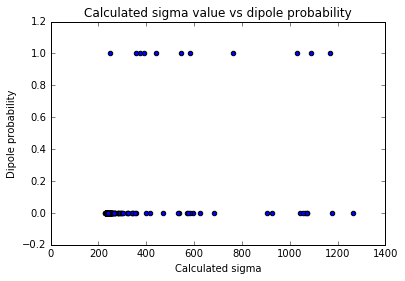

In [373]:
plt.scatter(sigmas, dip_prob)
plt.title('Calculated sigma value vs dipole probability')
plt.xlabel("Calculated sigma")
plt.ylabel("Dipole probability")

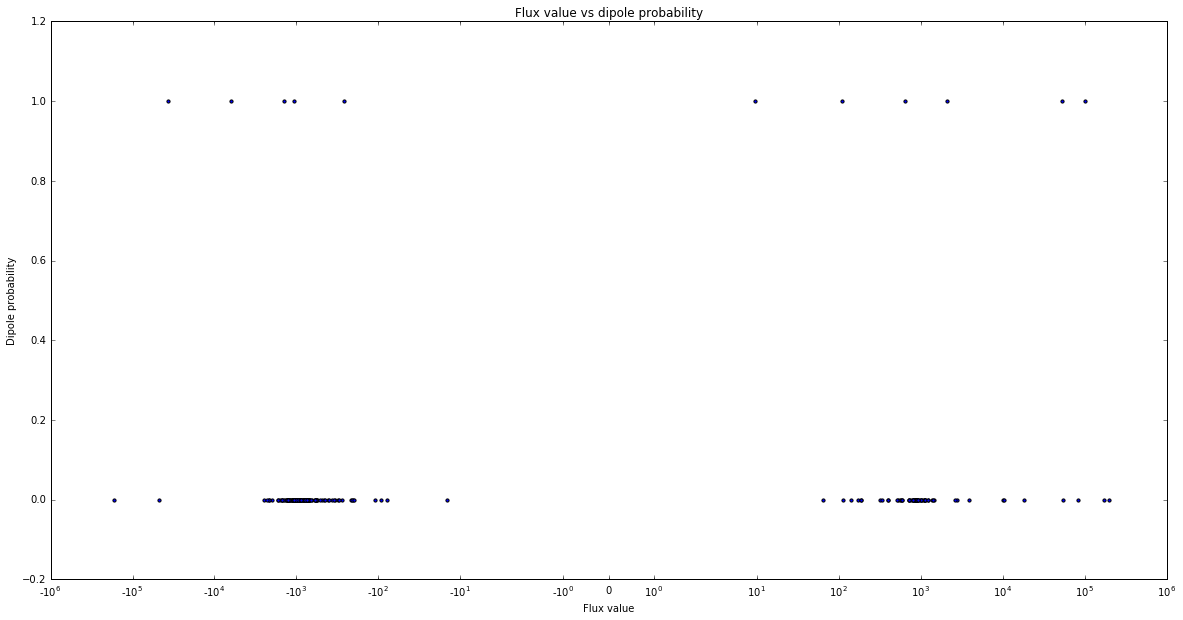

In [374]:
plt.figure(figsize=(20,10))
plt.scatter(fluxes, dip_prob, s=10)
ax=plt.axes()
ax.set_xscale('symlog')
plt.title('Flux value vs dipole probability')
plt.xlabel("Flux value")
plt.ylabel("Dipole probability")

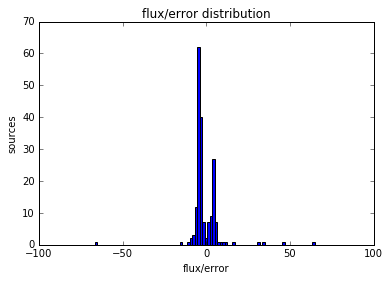

In [376]:
plt.hist(error_values, bins=500)
axes = plt.axes()
axes.set_xlim(xmin=-100, xmax=100)
plt.ylabel("sources")
plt.xlabel("flux/error")
plt.title("flux/error distribution")

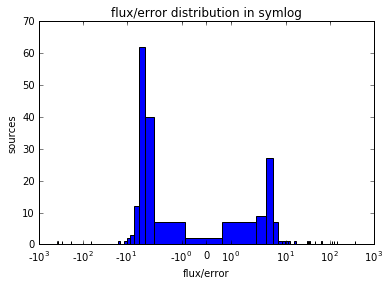

In [377]:
plt.hist(error_values, bins=500)

ax=plt.axes()
ax.set_xscale('symlog')
plt.ylabel("sources")
plt.xlabel("flux/error")
plt.title("flux/error distribution in symlog")

In [341]:


sigmas_pos=[]
sigmas_neg=[]
fluxes_pos=[]
fluxes_neg=[]
diaSrcs_pos=[]
diaSrcs_neg=[]

for flux, sigma, diaSrc in zip(fluxes, sigmas, diaSrcs ):
    
    if np.isnan(sigma)==False:
        if flux < 0:
            sigmas_neg.append(sigma)
            
        elif flux > 0:
            sigmas_pos.append(sigma)
            

sigma_pos = np.mean(sigmas_pos)
sigma_neg = -np.mean(sigmas_neg)

for flux, diaSrc in zip(fluxes, diaSrcs):
    
    if flux > sigma_pos*5:
        fluxes_pos.append(flux)
        diaSrcs_pos.append(diaSrc)
    elif flux < sigma_neg*5:
        fluxes_neg.append(flux)
        diaSrcs_neg.append(diaSrc)

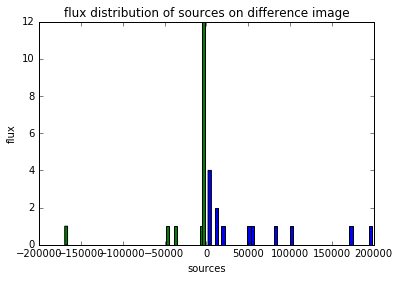

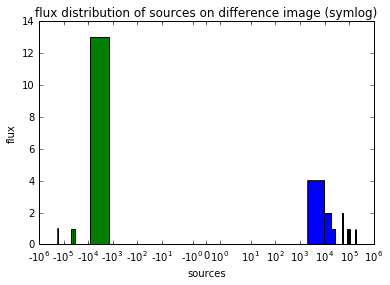

In [342]:
plt.hist(fluxes_pos, bins=50)
plt.hist(fluxes_neg, bins=50)
plt.xlabel("sources")
plt.ylabel("flux")
plt.title("flux distribution of sources on difference image")
plt.show()

plt.hist(fluxes_pos, bins=25)
plt.hist(fluxes_neg, bins=25)
ax=plt.axes()
ax.set_xscale('symlog')
plt.xlabel("sources")
plt.ylabel("flux")
plt.title("flux distribution of sources on difference image (symlog)")
plt.show()

In [343]:
ds9.mtv(subtractedExposure)

In [344]:
frame = 0
im = displayUtils.Mosaic(gutter=5, background=5, mode="square")
for ds in diaSrcs_pos:
    try:
        s1, s2, s3 = get_stamps_for_diaSource(ds,scienceExposure, templateExposure, subtractedExposure)
        im.append(s3.getMaskedImage())
        
        ds9.mtv(s3, frame=frame)
        ds9.setMaskTransparency(100,frame=frame)
        frame+=1
    except:
        pass
im.makeMosaic(frame=frame, title="mosaic")

<lsst.afw.image.imageLib.MaskedImageF; proxy of <Swig Object of type 'boost::shared_ptr< lsst::afw::image::MaskedImage< float,lsst::afw::image::MaskPixel,lsst::afw::image::VariancePixel > > *' at 0x7f854aa26780> >

In [372]:
frame = 0
im = displayUtils.Mosaic(gutter=5, background=5, mode="square")
for ds in diaSrcs_pos:
    try:
        s1, s2, s3 = get_stamps_for_diaSource(ds,scienceExposure, templateExposure, subtractedExposure)
        im.append(s3.getMaskedImage())
        
        ds9.mtv(s3, frame=frame)
        ds9.setMaskTransparency(100,frame=frame)
        frame+=1
    except:
        pass
im.makeMosaic(frame=frame, title="mosaic", background='r')

<lsst.afw.image.imageLib.MaskedImageF; proxy of <Swig Object of type 'boost::shared_ptr< lsst::afw::image::MaskedImage< float,lsst::afw::image::MaskPixel,lsst::afw::image::VariancePixel > > *' at 0x7f8562f875a0> >

In [346]:

pos_det_sizes = []
for src in diaSrcs_pos:
    pos_det=0

    
    s1, s2, s3 = get_stamps_for_diaSource(src,scienceExposure, templateExposure, subtractedExposure)
    if s1!=False:

        mi = s3.getMaskedImage()
        m = mi.getMask()
        m_d = m.getPlaneBitMask("DETECTED")


        
        for x in range(0, mi.getWidth()):        
            for y in range (0, mi.getHeight()):
                u =  mi.getMask()[x,y]  

                if np.isnan(mi.getImage().get(x,y))==False:
                    u =  mi.getMask()[x,y]            
                    m_val =    u.get(0,0)
                    
                    if m_val != 0 and (m_val & m_d == m_d):
                            pos_det += 1
                      
    pos_det_sizes.append(pos_det)
 



    

In [347]:

neg_det_sizes = []
for src in diaSrcs_neg:

    neg_det=0
    
    s1, s2, s3 = get_stamps_for_diaSource(src,scienceExposure, templateExposure, subtractedExposure)
    if s1!=False:

        mi = s3.getMaskedImage()
        m = mi.getMask()

        m_dn = m.getPlaneBitMask("DETECTED_NEGATIVE")

        
        for x in range(0, mi.getWidth()):        
            for y in range (0, mi.getHeight()):
                u =  mi.getMask()[x,y]  

                if np.isnan(mi.getImage().get(x,y))==False:
                    u =  mi.getMask()[x,y]            
                    m_val =    u.get(0,0)
                    
                    if m_val != 0 and (m_val & m_dn == m_dn):
                            neg_det += 1

    neg_det_sizes.append(neg_det)

In [348]:
print len(neg_det_sizes), len(fluxes_neg)

16 16


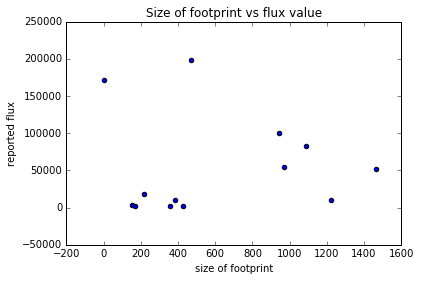

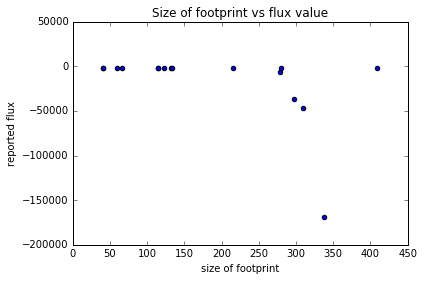

In [370]:
plt.scatter(pos_det_sizes, fluxes_pos)
plt.xlabel("size of footprint")
plt.ylabel("reported flux")
plt.title("Size of footprint vs flux value")
plt.show()


plt.scatter(neg_det_sizes, fluxes_neg)
plt.xlabel("size of footprint")
plt.ylabel("reported flux")
plt.title("Size of footprint vs flux value")
plt.show()

In [350]:
dataId = {'visit': 800719, 'filter':'r' , 'ccd':14}
normal_srcs = butler.get("src", dataId)
#diffExp = butler.get("deepDiff_differenceExp", dataId)

In [351]:
normal_fluxes = [normal_srcs.getApFlux()]

In [352]:
smVector = afwTable.matchXy(normal_srcs, cat, 5, True)

In [353]:
print len(smVector)

24


In [354]:
t_diaSrcs = []
t_diaSrcs.extend(diaSrcs_pos)
t_diaSrcs.extend(diaSrcs_neg)

In [355]:


cat = afwTable.SourceCatalog(t_diaSrcs[-1].schema)

In [356]:
for diaSrc in t_diaSrcs:
    cat.append(diaSrc)
               

In [357]:
cat2 = cat.copy(deep=True)

In [358]:
smVector = afwTable.matchRaDec(cat, normal_srcs, afwTable.Angle(1.0/3600), True)

In [359]:
dia_matches = []
sci_matches = []
for match in smVector:
    dia_matches.append(match.first.get('base_CircularApertureFlux_6_0_flux'))
    sci_matches.append(match.second.getApFlux())

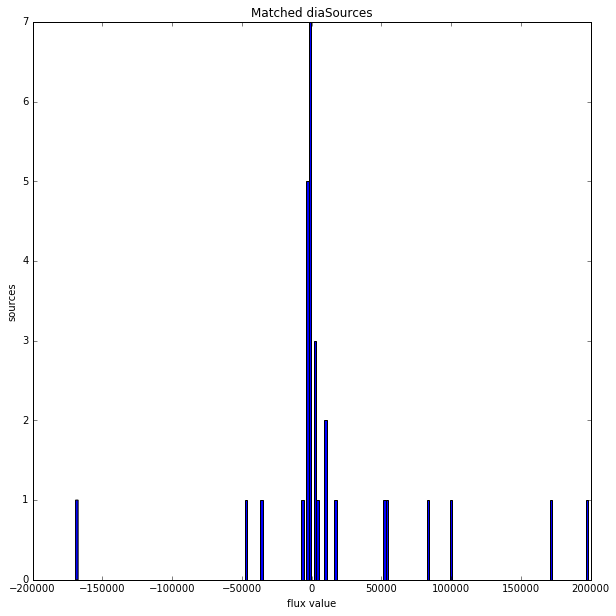

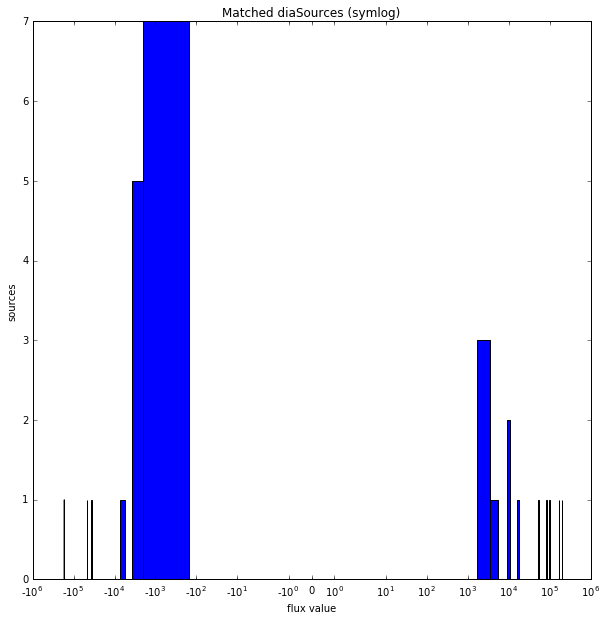

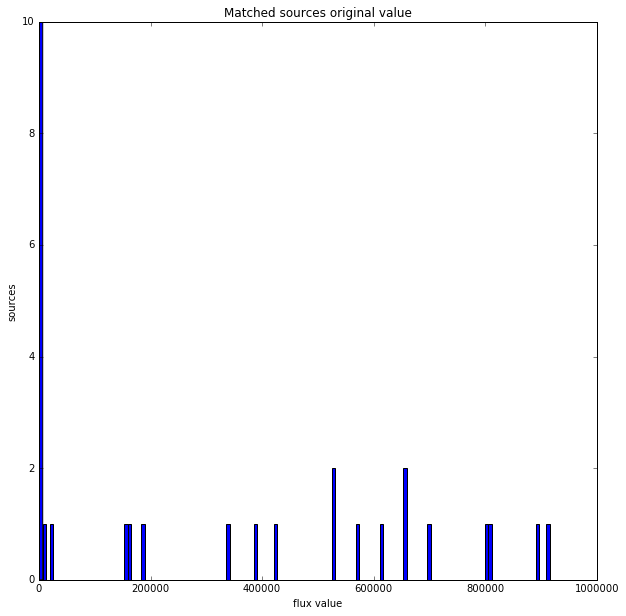

In [369]:

plt.figure(figsize=(10,10))
plt.hist(dia_matches, bins=200)
plt.xlabel("flux value")
plt.ylabel("sources")
plt.title("Matched diaSources")
plt.show()

plt.figure(figsize=(10,10))
plt.hist(dia_matches, bins=200)
ax=plt.axes()
ax.set_xscale('symlog')
plt.xlabel("flux value")
plt.ylabel("sources")
plt.title("Matched diaSources (symlog)")
plt.show()

plt.figure(figsize=(10,10))
plt.hist(sci_matches, bins=150)
plt.xlabel("flux value")
plt.ylabel("sources")
plt.title("Matched sources original value")
plt.show()

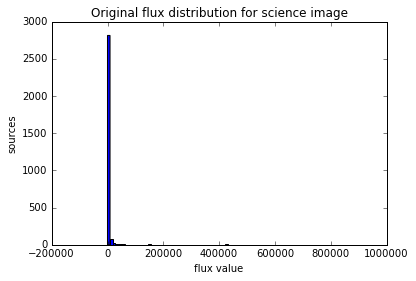

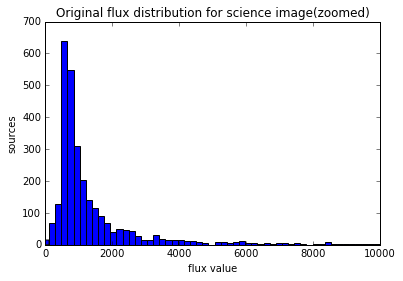

In [371]:
plt.hist(normal_fluxes, bins=100)
plt.xlabel("flux value")
plt.ylabel("sources")
plt.title("Original flux distribution for science image")
plt.show()

plt.hist(normal_fluxes, bins=5000)
plt.xlabel("flux value")
plt.ylabel("sources")
plt.title("Original flux distribution for science image(zoomed)")
ax=plt.axes()
ax.set_xlim(xmin=0, xmax=10000)
plt.show()